本实践使用CNN模型，用于预测手写数字图片

首先需要导入的包：
    numpy
    
    PIL python image library ,第三方图像处理库
    
    matplotlib 
    
    os 提供了丰富的方法来处理文件和目录 
    
    torchvision 提供了下载很多数据集，包括COCO、ImageNet、CIFCAR等

In [1]:
import numpy as np
import torch
torch.cuda.current_device()
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import datasets,transforms,utils

# Step1:准备数据

(1)数据介绍

MNIST数据包包含60000个训练和10000个测试集。分为图片和标签，图片是28*28的像素矩阵，标签为0-9共10个数字

(2)data_train和data_test root为数据集存放的路径，transform指定数据集导入的时候需要进行的变换，train设置为true表明导入的是训练集合，
否则会测试集合。 Compose是把多种数据处理的方法集合在一起。使用transform进行Tensor格式转换和Batch Normalization。

(3)打印看下载数据是什么样的？数据已经经过transform的归一化处理


class torchvision.tranforms.Normalize(mean,std):
    
    给定均值：(R,G,B)方差：(R,G,B) 将会把Tensor正则化。
    
    即：Normalized_image=(image-mean)/std.
    
    MNIST是(1,28,28),不是RGB的三维，只是一维的灰度图像数据，所以不是[0.5,0.5,0.5]而是[0.5]

In [2]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5],std=[0.5])])

In [3]:
train_data=datasets.MNIST(root="./data/",transform=transform,train=True,download=True)
test_data=datasets.MNIST(root="./data/",transform=transform,train=False)

In [4]:
len(test_data)

10000

train_data的个数：60000个训练样本

test_data的个数：10000个训练样本

一个样本的格式为[data,label], 第一个存放数据，第二个存放标签

num_workers 表示用多少个子进程加载数据

shuffle表示在装载过程中随机乱序

In [5]:
train_loader=torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=64,shuffle=True)

In [6]:
dataiter=iter(test_loader)
images,labels=dataiter.next()

In [7]:
labels

tensor([3, 6, 3, 4, 6, 4, 1, 3, 1, 5, 3, 2, 7, 2, 8, 4, 7, 5, 8, 6, 0, 9, 6, 1,
        0, 3, 8, 3, 0, 9, 0, 5, 8, 2, 1, 9, 9, 0, 5, 6, 3, 1, 0, 9, 6, 6, 1, 8,
        8, 0, 3, 9, 5, 4, 0, 0, 1, 1, 0, 0, 0, 3, 8, 9])

设置batch_size=64后，加载器中的基本单位是一个batch的数据

所以train_loader的长度为60000/64=938个batch

test_loader的长度是10000/64=157个batch

In [8]:
print(len(train_loader))
print(len(test_loader))

938
157


加载到dataloader中后，一个dataloader是一个batch的数据

In [9]:
#data_iter=iter(train_loader)
#print(next(data_iter))

从二维数组中生成一张图片

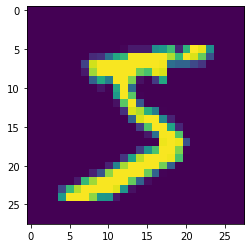

In [10]:
oneing,label=train_data[0]
oneing=oneing.numpy().transpose(1,2,0)
std=[0.5]
mean=[0.5]
oneing=oneing*std+mean
oneing.resize(28,28)
plt.imshow(oneing)
plt.show()

从三维生成一张黑白图片

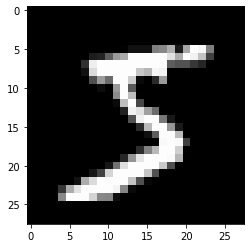

In [11]:
oneing,label=train_data[0]
grid=utils.make_grid(oneing) #将若干幅图像拼成一幅图像
grid=grid.numpy().transpose(1,2,0)  #将0，1,2的维度换成1,2,0的样子
std=[0.5]
mean=[0.5]
grid=grid*std+mean
plt.imshow(grid)
plt.show()

通俗理解：shape=(C,H,W)，也就是有C个H*W的二维矩阵。不管怎么转置，第一位为C，第二位为H，第三位W，这是恒定不变的，变得只是其对应的数值。比如shape=(3，4，5），有3个4*5的二维矩阵组成的三维矩阵，此时通过transpose变换，shape=(4，3，5)，有4个3*5的矩阵组成的三维矩阵。这样想就很容易看出来是怎样变换的了。

输出一个batch的图片和标签

tensor(8) tensor(4) tensor(7) tensor(2) tensor(6) tensor(5) tensor(4) tensor(5) 
tensor(9) tensor(6) tensor(6) tensor(5) tensor(5) tensor(8) tensor(2) tensor(8) 
tensor(4) tensor(9) tensor(7) tensor(7) tensor(9) tensor(9) tensor(4) tensor(1) 
tensor(3) tensor(0) tensor(4) tensor(3) tensor(2) tensor(1) tensor(0) tensor(6) 
tensor(4) tensor(4) tensor(9) tensor(2) tensor(3) tensor(2) tensor(2) tensor(4) 
tensor(8) tensor(3) tensor(2) tensor(4) tensor(8) tensor(0) tensor(2) tensor(8) 
tensor(4) tensor(4) tensor(0) tensor(4) tensor(7) tensor(8) tensor(0) tensor(5) 
tensor(9) tensor(9) tensor(1) tensor(1) tensor(0) tensor(5) tensor(0) tensor(8) 


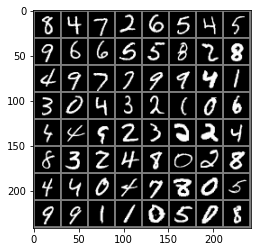

In [12]:
images,labels=next(iter(train_loader))
img=utils.make_grid(images)
img=img.numpy().transpose(1,2,0)
std=[0.5]
mean=[0.5]
img=img*std+mean
for i in range(64):
    print(labels[i],end=" ")
    i+=1
    if i%8 is 0:
        print(end="\n")

plt.imshow(img)
plt.show()

# Step2.网络配置

网络结构是两个卷积层，3个全连接层。

Conv2d参数

    in_channels(int)-输入信号的通道数目
    out_channels(int)-卷积产生的通道数目
    kerner_size(int or tuple)-卷积核的尺寸
    stride(int or tuple,optional)-输入的每一条边补充0的层数
    

1.定义一个CNN网络

In [13]:
import torch.nn.functional as F

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1=nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1) #out_channels是自定义的，也就是输出的特征个数
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.fc1=nn.Linear(64*7*7,1024)  #两个池化，所以是7*7而不是14*14
        self.fc2=nn.Linear(1024,512) #Linear代表的是全连接的意识
        self.fc3=nn.Linear(512,10)
#       self.dp=nn.Dropout(p=0.5)

    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,64*7*7) #将数据平整为一维的
        x=F.relu(self.fc1(x))
    #   x=self.fc3(x)
    #   self.dp(x)
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
    #   x=F.log_softmax(x,dim=1) NLLLoss()才需要，交叉熵不需要
        return x

net=CNN()

定义损失函数和优化函数

In [15]:
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
#也可以选择Adam优化方法
#optimizer=optim.Adam(net.parameters(),lr=le-2)

# Step3.模型训练

In [16]:
train_accs=[]
train_loss=[]
test_accs=[]
device=torch.device("cuda:0")
net=net.to(device)
for epoch in range(5):
    running_loss=0.0
    for i,data in enumerate(train_loader,0): #0是下标起始位置默认为0
        # data的格式[[inputs,labels]]
        #inputs,labels=data
        inputs,labels=data[0].to(device),data[1].to(device)
        #初始为0，清楚上个batch的梯度信息
        optimizer.zero_grad()
        
        #前项加后项加优化
        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        #loss的输出，每个一百个batch输出，平均loss
        running_loss+=loss.item()
        if i%100==99:
            print("[%d,%5d] loss:%.3f"%(epoch+1,i+1,running_loss/100))
            running_loss=0.0
        train_loss.append(loss.item())
        
        #训练曲线的绘制 一个batch中的准确率
        correct=0
        total=0
        _,predicted=torch.max(outputs.data,1)
        total=labels.size(0) #labels的长度
        correct=(predicted==labels).sum().item()  #预测正确的数目
        train_accs.append(100*correct/total)
print("Finished Training")

[1,  100] loss:2.289
[1,  200] loss:2.245
[1,  300] loss:2.141
[1,  400] loss:1.777
[1,  500] loss:1.017
[1,  600] loss:0.598
[1,  700] loss:0.482
[1,  800] loss:0.387
[1,  900] loss:0.349
[2,  100] loss:0.299
[2,  200] loss:0.299
[2,  300] loss:0.266
[2,  400] loss:0.251
[2,  500] loss:0.239
[2,  600] loss:0.233
[2,  700] loss:0.195
[2,  800] loss:0.190
[2,  900] loss:0.176
[3,  100] loss:0.158
[3,  200] loss:0.153
[3,  300] loss:0.162
[3,  400] loss:0.147
[3,  500] loss:0.141
[3,  600] loss:0.132
[3,  700] loss:0.135
[3,  800] loss:0.119
[3,  900] loss:0.131
[4,  100] loss:0.107
[4,  200] loss:0.104
[4,  300] loss:0.102
[4,  400] loss:0.099
[4,  500] loss:0.111
[4,  600] loss:0.104
[4,  700] loss:0.097
[4,  800] loss:0.097
[4,  900] loss:0.092
[5,  100] loss:0.089
[5,  200] loss:0.089
[5,  300] loss:0.074
[5,  400] loss:0.074
[5,  500] loss:0.085
[5,  600] loss:0.087
[5,  700] loss:0.091
[5,  800] loss:0.078
[5,  900] loss:0.075
Finished Training


模型保存

In [17]:
PATH="./mnist_net.pth"
torch.save(net.state_dict(),PATH)

# Step4.模型评估

画图

In [18]:
def draw_train_process(title,iters,costs,accs,label_cost,label_acc):
    plt.figure(figsize=[16,8])
    plt.title(title,fontsize=24)
    plt.xlabel("iter",fontsize=20)
    plt.ylabel("acc(\%)",fontsize=20)
    plt.plot(iters,costs,color="red",label=label_cost)
    plt.plot(iters,accs,color="green",label=label_acc)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

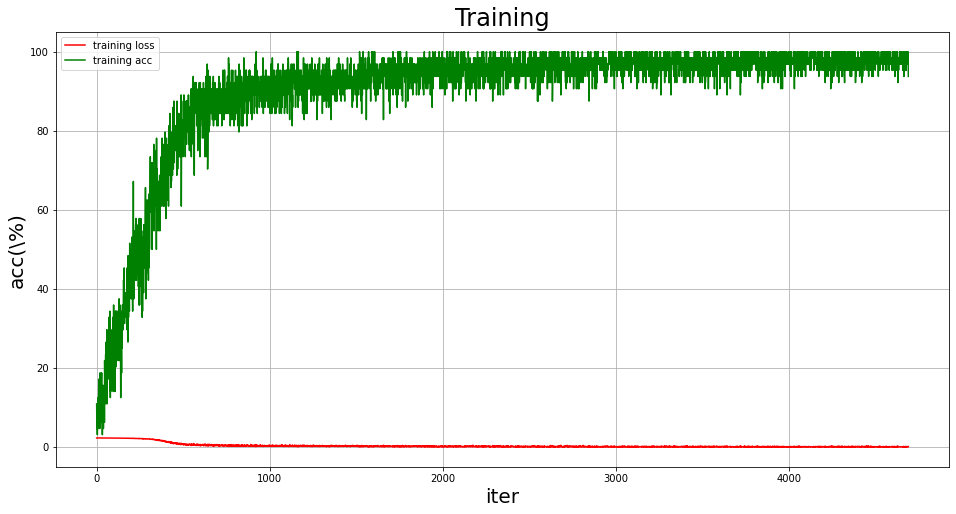

In [19]:
train_iters=range(len(train_accs))
draw_train_process("Training",train_iters,train_loss,train_accs,"training loss","training acc")

检验一个batch的分类情况

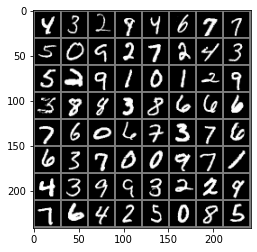

GroundTruth: 4 3 2 9 4 6 7 7 5 0 9 2 7 2 4 3 5 2 9 1 0 1 2 9 3 8 8 3 8 6 6 6 7 6 0 6 7 3 7 6 6 3 7 0 0 9 7 1 4 3 9 9 3 2 2 9 7 6 4 2 5 0 8 5


In [20]:
datailter=iter(test_loader)
images,labels=dataiter.next()

#print images
test_img=utils.make_grid(images)
test_img=test_img.numpy().transpose(1,2,0)
std=[0.5,0.5,0.5]
mean=[0.5,0.5,0.5]
test_img=test_img*std+0.5
plt.imshow(test_img)
plt.show()
print("GroundTruth:"," ".join("%d"%labels[j] for j in range(64)))

In [21]:
test_net=CNN()
test_net.load_state_dict(torch.load(PATH))
test_out=test_net(images)

输出的是每一类的对应概率，所以需要选择max来确定最终输出的类别，dim=1表示选择行的最大索引

In [22]:
print(test_out)
_,predicted=torch.max(test_out,dim=1)
print("Predicted:"," ".join("%d"%predicted[j] for j in range(64)))

tensor([[-3.4977e+00, -1.6864e+00, -2.1650e+00, -5.7293e+00,  1.2708e+01,
         -3.7110e+00,  6.6628e-01, -1.1736e+00,  5.5731e+00,  1.0456e+00],
        [-3.5850e+00,  1.3315e+00,  8.7446e-01,  9.9435e+00, -7.4197e+00,
          3.5477e+00, -6.8427e+00, -4.4855e+00,  3.9232e+00,  2.4748e+00],
        [-9.8927e-01,  4.9422e+00,  7.3283e+00,  2.7208e+00, -3.9456e+00,
         -3.1203e+00, -1.5857e+00, -4.5832e-01, -1.2075e+00, -3.9166e+00],
        [-6.1031e+00, -1.3496e+00, -3.3864e+00,  1.3073e+00,  2.9021e+00,
         -9.4297e-02, -9.5124e+00,  5.3643e+00,  4.7309e+00,  8.3729e+00],
        [-6.4337e+00, -7.7854e-02, -3.6781e+00, -1.8480e+00,  1.1397e+01,
         -1.2318e+00, -2.7906e+00,  4.5069e-01,  2.3086e+00,  4.9660e+00],
        [ 2.1260e+00, -3.3928e-01, -6.9829e-01, -1.7294e+00, -7.8991e-01,
          9.0584e-03,  8.0753e+00, -7.5491e+00,  3.3884e+00, -2.7592e+00],
        [-1.9264e+00, -1.2952e+00, -6.3596e-02,  8.2606e-02,  8.0139e-01,
         -3.5559e+00, -1.1850e+0

测试集上面整体的准确率

In [23]:
correct=0
total=0
with torch.no_grad(): #测评的时候网络不更新梯度
    for data in test_loader:
        images,labels=data
        outputs=test_net(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
print("Accuracy of the network on the test image: %f %%"%(100.*correct/total))

Accuracy of the network on the test image: 97.960000 %


10个类别的准确率

In [24]:
class_correct=list(0. for i in range(10))
class_total=list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images,labels=data
        outputs=test_net(images)
        _,predicted=torch.max(outputs,1)
        c=(predicted==labels)
        
        for i in range(10):
            label=labels[i]
            class_correct[label]+=c[i].item()
            class_total[label]+=1
            
for i in range(10):
    print("Accurracy of %d : %4f %%"%(i,100*class_correct[i]/class_total[i]))

Accurracy of 0 : 98.000000 %
Accurracy of 1 : 100.000000 %
Accurracy of 2 : 97.802198 %
Accurracy of 3 : 99.390244 %
Accurracy of 4 : 96.551724 %
Accurracy of 5 : 99.295775 %
Accurracy of 6 : 98.581560 %
Accurracy of 7 : 93.750000 %
Accurracy of 8 : 97.916667 %
Accurracy of 9 : 95.027624 %


dataloader本质是一个可迭代对象，使用iter()访问，不能使用next()访问；

使用iter(dataloader)返回的是一个迭代器，然后可以使用next访问；

也可以使用`for inputs, labels in dataloaders`进行可迭代对象的访问；
 
本质上类似list